In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import re
import torch.utils.data as data
from dataclasses import dataclass

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

from avae.model import AttentionVae, GPTConfig
from avae.dataset import CharDataset
from avae.trainer import TrainerConfig, Trainer

from torch.utils.tensorboard import SummaryWriter


In [3]:
writer = SummaryWriter('runs/avae')

This notebook is used to load the model and trains it on some data.

Point the model to a local corpus dataset.

For example download wiki-text2 here:
https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip

# Data utils

In [4]:
PROJECT_DIR  = Path(".").resolve().parent.parent
DATA_DIR  = PROJECT_DIR / "data"
WIKI_DIR  = DATA_DIR / "wikitext-2"
NAMES_DIR  = DATA_DIR / "names"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
def clean_word(word):
    word = word.replace("\n", '').lower()
    return word

REGEX = re.compile("[^a-z-'\-]")

def validate(word):
    if REGEX.findall(word):
        return False
    if len(word)<=2:
        return False
    return True

def clean_word_wiki(line):
    line = line.replace("\n", '').lower()
    line = line.split(" ")
    line = [word for word in line if validate(word)]
    return line

In [6]:
wiki = []

with open(WIKI_DIR / "train.txt", "r") as f:
    for word in f:
        wiki.extend(clean_word_wiki(word))

In [7]:
all_names = wiki

raw_text = " ".join(all_names)
maxlen = len(max(all_names, key=len)) + 1
chars = sorted(list(set(raw_text)))
mapping = dict((c, i+1) for i , c in enumerate(chars))
mapping["0"] = 0
inverse_mapping = dict((k,v) for v,k in mapping.items())


In [8]:
# raw_text = raw_text[:557193]

In [9]:
def pad_word(word, length=20):
    before = "0"
    after = "0" * ((length  - len(word))+1)
    word = before + word + after
    return word

def depad_word(word, length=20):
    word = word.replace("0", '')
    return word

def encode_word(word, mapping, length=20):
    word = pad_word(word, length=length)
    return [mapping[char] for char in word]

def decode_word(word, inverse_mapping, length=20):
    char_list = [depad_word(inverse_mapping[char], length=length) for char in word]
    return ''.join(char_list)


In [10]:
def vec2word(vec, mapping):
#     int_vec = np.rint(np.squeeze(vec) * len(mapping)).astype(int)
    inverse_mapping = dict((k,v) for v,k in mapping.items())
    words = []
    for word in vec:
        words.append(decode_word(word, inverse_mapping))
    return words

all_data = np.array([encode_word(name, mapping, length=maxlen) for name in all_names])
for orig, word in zip(all_names, vec2word(all_data, mapping)):
    assert orig == word

In [11]:
# Dataset returns 3 values: the  word up to letter i, the word up to letter i+1 (target for prediction) 
# and the full word
train_dataset = CharDataset(raw_text, maxlen)

data has 8557193 characters, 30 unique.


In [13]:
idx=7
x, y, word = train_dataset[idx]
print(decode_word(x.numpy(), inverse_mapping))
print(decode_word(y.numpy(), inverse_mapping))

valkyri
valkyria


In [14]:
idx=400
x, y, word = train_dataset[idx]
print("x: ",decode_word(x.numpy(), inverse_mapping))
print("y: ",decode_word(y.numpy(), inverse_mapping))
print("word :", decode_word(word.numpy(), inverse_mapping))

x:  nam
y:  name
word : nameless


# Build the network

In [15]:
config = GPTConfig(train_dataset.vocab_size, maxlen, n_layer=2, n_head=4, n_embd=64)
vae = AttentionVae(config)

number of parameters: 846592


## Building a tensorboard graph

In [16]:
# get a batch of data

x ,y,word  = [], [],[]
for i in range(10):
    batch = train_dataset[i]
    x.append(batch[0])
    y.append(batch[1])
    word.append(batch[2])
    
x = torch.stack(x, dim=0)
y = torch.stack(y, dim=0)
word = torch.stack(word, dim=0)

In [17]:
# Writing graph to tensorboard
writer.add_graph(vae, (x,y,word))
writer.close()

/home/simon/code/namegen/avae/src/avae/model.py:395: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  t <= self.block_size
/home/simon/code/namegen/avae/src/avae/model.py:399: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  position_embeddings = self.pos_emb[:, :t, :]
/home/simon/code/namegen/avae/src/avae/model.py:183: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generali

# Training

In [18]:
tconf = TrainerConfig(
    max_epochs=1,
    batch_size=1024,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=512 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
)
trainer = Trainer(vae, train_dataset, None, tconf)
losses = trainer.train()

  0%|          | 0/8357 [00:00<?, ?it/s]/home/simon/code/namegen/avae/src/avae/trainer.py:84: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  model.parameters(), config.grad_norm_clip
epoch 1) iter 0: train_loss 535.7503662, lr = 6.000000e-04:   0%|          | 1/8357 [00:00<2:14:56,  1.03it/s]

Iteration 0 samples:
r
s--csl
scr
q-pqrcqmctpkstbmjctg
jq


epoch 1) iter 1000: train_loss 221.1741638, lr = 5.947098e-04:  12%|█▏        | 1001/8357 [03:37<33:37,  3.65it/s]

Iteration 1000 samples:
centurol
are
was
respailly
contin


epoch 1) iter 2000: train_loss 219.8919067, lr = 5.790368e-04:  24%|██▍       | 2001/8357 [07:14<28:57,  3.66it/s]

Iteration 2000 samples:
sengs
stougge
immant
seasid
earm


epoch 1) iter 3000: train_loss 218.8429260, lr = 5.535329e-04:  36%|███▌      | 3001/8357 [10:51<24:38,  3.62it/s]

Iteration 3000 samples:
acn
goner
addian
fortaly
indiars


epoch 1) iter 4000: train_loss 218.3580933, lr = 5.190969e-04:  48%|████▊     | 4001/8357 [14:27<20:04,  3.62it/s]

Iteration 4000 samples:
eflumations
film
uritic
ubstoronst
inisted


epoch 1) iter 5000: train_loss 217.6841431, lr = 4.769419e-04:  60%|█████▉    | 5001/8357 [18:04<15:15,  3.67it/s]

Iteration 5000 samples:
failink
fulter
event
game
guarst


epoch 1) iter 6000: train_loss 217.1611481, lr = 4.285530e-04:  72%|███████▏  | 6001/8357 [21:41<10:46,  3.65it/s]

Iteration 6000 samples:
action
casoched
office
magr
background


epoch 1) iter 7000: train_loss 217.2059631, lr = 3.756351e-04:  84%|████████▍ | 7001/8357 [25:17<06:13,  3.63it/s]

Iteration 7000 samples:
but
bard
the
the
the


epoch 1) iter 8000: train_loss 216.9461060, lr = 3.200525e-04:  96%|█████████▌| 8001/8357 [28:54<01:37,  3.65it/s]

Iteration 8000 samples:
instid
marie
muscon
many
van


epoch 1) iter 8356: train_loss 217.1692657, lr = 3.000134e-04: 100%|██████████| 8357/8357 [30:11<00:00,  4.61it/s]


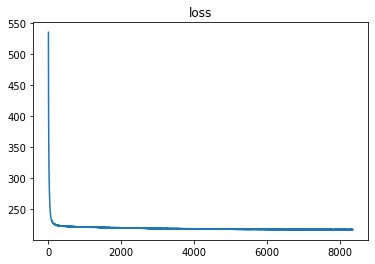

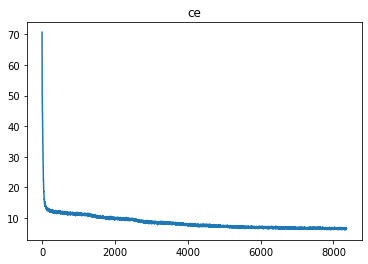

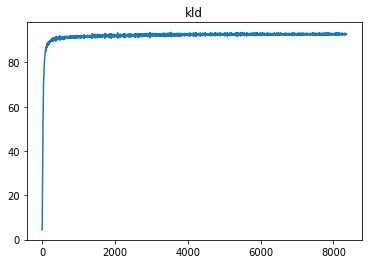

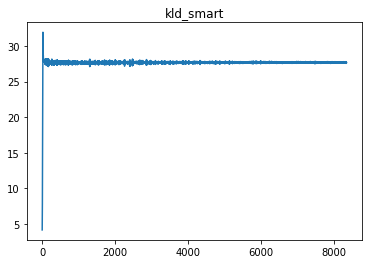

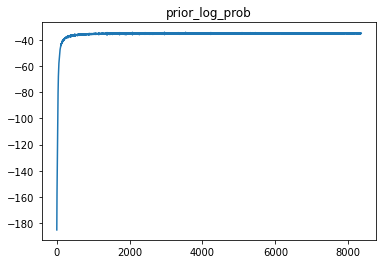

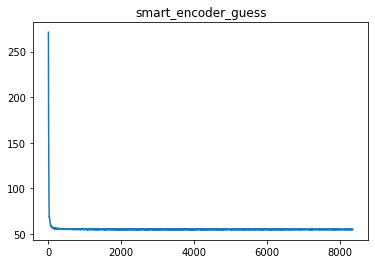

In [19]:
for k, v in losses.items():
    plt.plot(v)
    plt.title(k)
    plt.show()

# Sample Generation

In [38]:
def generate_samples(initial_context, vae, n_samples=10, method='smart', sample=False, temperature=1.0):
    context = "0" * (vae.config.block_size -len(initial_context) ) + initial_context
    x = torch.tensor([trainer.train_dataset.stoi[s] for s in context], dtype=torch.long,)[
        None, ...
    ].to(trainer.device)
    x = torch.repeat_interleave(x, n_samples, dim=0)
    y = vae.sample(x,20,sample=sample, method=method, temperature=temperature)
    
    completions = []
    for sent in y:
        completion = "".join(
            [trainer.train_dataset.itos[int(i)] for i in sent]
        )
        completions.append(
            completion[vae.config.block_size -len(initial_context) :].split(
                "0"
            )[0]
        )
    return completions

In [42]:
initial_context = "lega"
outputs = generate_samples(initial_context, vae)
for out in outputs:
    print(out)

legad
legate
legated
legard
legan
legas
legation
legan
legate
legarding


# Checking the various components of the network are doing something

In [32]:
# This network uses a "smart_encoder" which attempts to learn how to encode a partial word
# the same way that a full word is encoded. 
# That way, latent info focuses on learning global info, like style word length etc..
# Let's check it works as expected.

idx = 1
loader = DataLoader(train_dataset, batch_size=128)
x, y, word = next(iter(loader))
x, y, word = x.cuda(), y.cuda(), word.cuda()

z = vae.encoder(word)
z_smart = vae.smart_encoder(x)
z_random = torch.randn_like(z)

print("smart distance ", ((z - z_smart)**2).mean())
print("naive distance ", ((z - z_random)**2).mean())


smart distance  tensor(0.1975, device='cuda:0', grad_fn=<MeanBackward0>)
naive distance  tensor(1.6966, device='cuda:0', grad_fn=<MeanBackward0>)


In [33]:
# Seems that the smart encoder does a good job at the level of the latent space
# New Question: are we just using the latent space as a random seed?
# Let's check by computing the losses when using the latent

idx = 1
loader = DataLoader(train_dataset, batch_size=128)
x, y, word = next(iter(loader))
x, y, word = x.cuda(), y.cuda(), word.cuda()


_, batch_losses = vae(x,y,word,True)
_, batch_losses = vae(x,y,word,True)

print("batch losses")
print(batch_losses['ce'].mean().cpu().detach().numpy())

print("naive z sampling losses: ")

m_k, log_s_k, m_v, log_s_v = torch.chunk(vae.encoder(word), 4, -1)

z_k = torch.randn_like(m_k)
z_v = torch.randn_like(m_k)
_, CE = vae.decoder(x, z_k, z_v, targets=y)
CE = CE.view(x.shape[0], -1).sum(1)
print(CE.mean().cpu().detach().numpy())



batch losses
10.008693
naive z sampling losses: 
24.092201


In [34]:
#Ok it looks like we're using the latent space for reconstruction. 
# what about the pathway where we sample using smart latent (but not full word)
idx = 1
loader = DataLoader(train_dataset, batch_size=128)
x, y, word = next(iter(loader))
x, y, word = x.cuda(), y.cuda(), word.cuda()


print("Smart encoding sampling losses: ")
m_k_smart, log_s_k_smart, m_v_smart, log_s_v_smart = torch.chunk(
    vae.smart_encoder(x), 4, -1
)

z_k = vae.reparametrize(m_k_smart, log_s_k_smart)
z_v = vae.reparametrize(m_v_smart, log_s_v_smart)
x, CE = vae.decoder(x, z_k, z_v, targets=y)
CE = CE.view(x.shape[0], -1).sum(1)
print(CE.mean().cpu().detach().numpy())


#Conclusion: smart encoding is helping!

# We're getting better reconstructions than if we ignored the encoder. 
# the benefit is that the smart encoder can be used during sampling

Smart encoding sampling losses: 
15.398792
